## DATA620 Project 2

#### Group Member: Mia Chen / Wei Zhou

Identify a large 2-node network dataset—you can start with a dataset in a repository.  

Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

What can you infer about each of the distinct groups?


### Import 2 node network Data

In [143]:
import networkx as net
import csv
import pandas as pd
import requests
import io
import math
# import community as com
from networkx.algorithms import community
import numpy as np
import networkx.algorithms.bipartite as bi
import matplotlib.pyplot as plt

### Import Data
The Facebook-like Forum Network was attained from the Tore Opsahl website: https://toreopsahl.com/datasets/#online_forum_network. The data represents an two-mode network among 899 users and 522 topics, where the connections are weighted on the ties based on the number of messages or characters that a user posted to a topic.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Galanopoulog/DATA620-Project-2/master/p2_data.csv')

In [6]:
data.shape

(7089, 3)

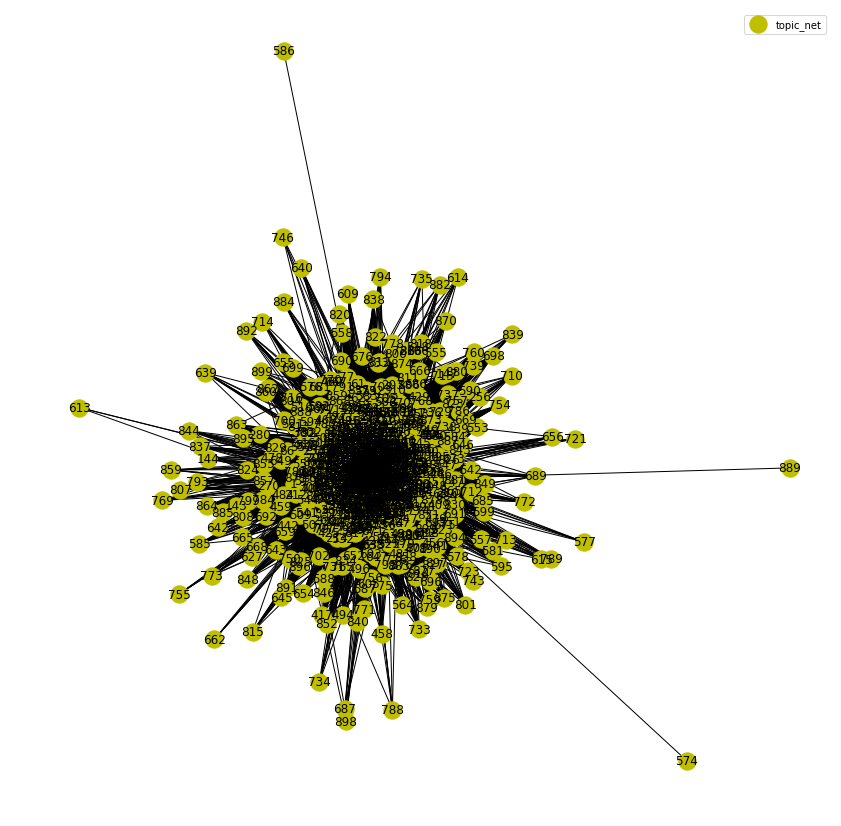

In [25]:
# Subgraph of topics
fb_g = net.Graph()
plt.figure(figsize=(11,11))
topic_net = bi.weighted_projected_graph(fb_g, topics, ratio=False)
topic_net = max(net.connected_component_subgraphs(topic_net),key=len)
weights = [math.log(edata['weight'])for f,t,edata in topic_net.edges(data=True)]

net.draw_spring(topic_net, label = 'topic_net', node_color='y',with_labels=True,node_size =300,font_color ='k')
plt.legend(["topic_net"])
plt.show()

In [81]:
print(net.info(topic_net))

Name: 
Type: Graph
Number of nodes: 899
Number of edges: 112724
Average degree: 250.7764


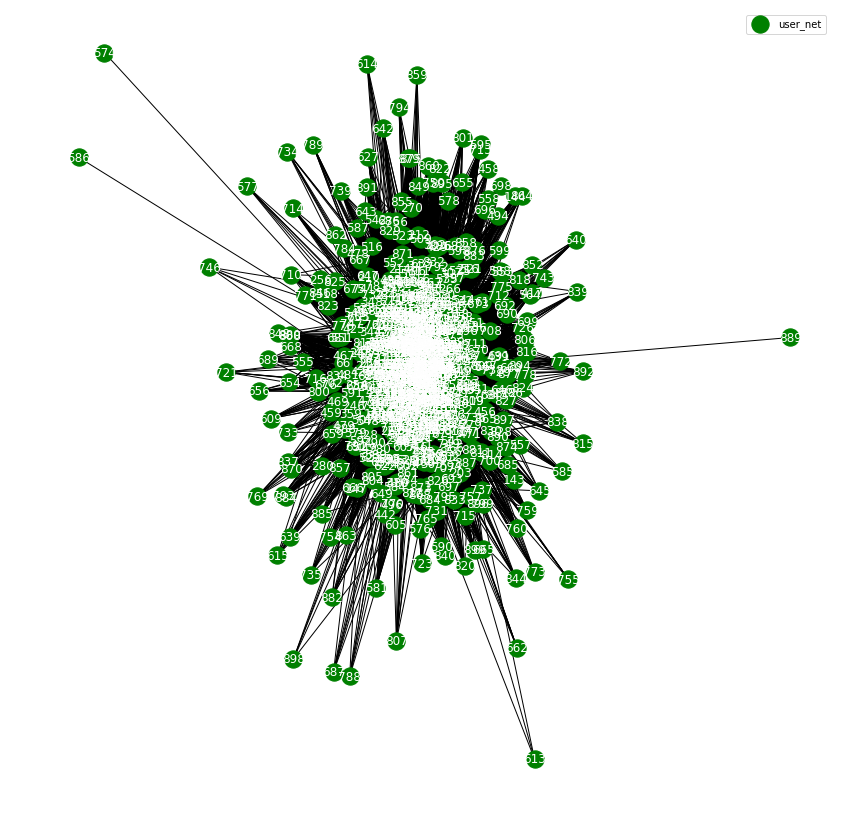

In [26]:
fb_g = net.Graph()
users = data.user.tolist()
topics = data.topic.tolist()
weights = data.weight.tolist()
for i in range(len(data)):
    fb_g.add_edge(users[i], topics[i], weight = weights[i])
    

# Subgraph of users
plt.figure(figsize=(11,11))
user_net = bi.weighted_projected_graph(fb_g, users, ratio=False)
user_net = max(net.connected_component_subgraphs(user_net),key=len)
weights = [math.log(edata['weight'])for f,t,edata in user_net.edges(data=True)]

net.draw_spring(topic_net, label = 'user_net', node_color='g', with_labels=True, node_size =300, font_color ='w')
plt.legend(["user_net"])
plt.show()

In [82]:
print(net.info(user_net))

Name: 
Type: Graph
Number of nodes: 899
Number of edges: 123231
Average degree: 274.1513


### Using the island method to further subset network. 

In [48]:
def trim_edges(fb_g, weight=1):
    fb_g2 = net.Graph()
    for f, to, edata in fb_g.edges(data=True):
        if edata['weight']> weight:
            fb_g2.add_edge(f,to,weight = edata['weight'])
    return fb_g2

In [86]:
def island_method(g, iterations=10):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step =((mx - mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in np.arange(mn,mx,step)]


In [89]:
topic_island = island_method(topic_net)
for i in topic_island:
    print (i[0],len(i[1]), net.number_connected_components(i[1]))


(1, 789, 1)
(4, 496, 1)
(7, 282, 1)
(10, 156, 3)
(13, 85, 3)
(16, 50, 2)
(19, 33, 1)
(22, 22, 1)
(25, 18, 4)
(28, 12, 3)
(31, 8, 3)
(34, 4, 2)


In [90]:
user_island = island_method(user_net)
for i in user_island:
    print (i[0],len(i[1]), net.number_connected_components(i[1]))


(1, 793, 1)
(4, 499, 1)
(7, 284, 1)
(10, 159, 3)
(13, 88, 4)
(16, 52, 3)
(19, 33, 1)
(22, 22, 1)
(25, 18, 4)
(28, 12, 3)
(31, 8, 3)
(34, 4, 2)


#### Trim user network

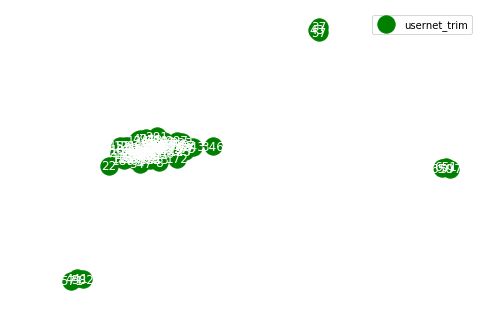

In [94]:
usernet_trim = trim_edges(user_net,weight= 13)
weights = [edata['weight'] for f,t,edata in usernet_trim.edges(data=True)]

net.draw_spring(usernet_trim, label = 'usernet_trim', node_color='g',with_labels=True,node_size =300,font_color ='w')
plt.legend(["usernet_trim"])
plt.show()

In [52]:
len(usernet_trim)

685

#### Trim topic network

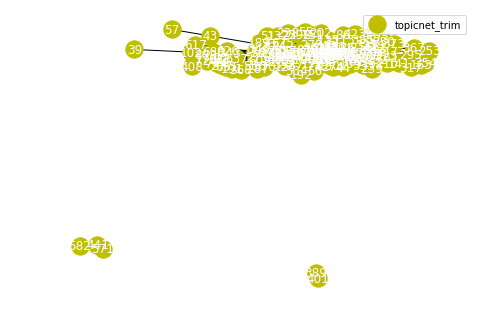

In [95]:
# Trimming the topic network
topicnet_trim = trim_edges(topic_net,weight= 10)
weights = [edata['weight'] for f,t,edata in usernet_trim.edges(data=True)]

net.draw_spring(topicnet_trim, label = 'topicnet_trim', node_color='y',with_labels=True,node_size =300,font_color ='w')
plt.legend(["topicnet_trim"])
plt.show()

In [54]:
len(topicnet_trim)

684

### Inferences
#### Find Top users


In [132]:
# Function defined sorted_map for sorting users/topics based on their centrality value
def sorted_map(map):
    ms= sorted(map.iteritems(),key=lambda(k,v):(-v,k))
    return ms

In [136]:
# Is the users graph directed?
user_ud = usernet_trim.to_undirected()
fb_components = net.connected_component_subgraphs(user_ud)
net.is_directed(user_ud)

False

In [151]:
# Compute Degree Measure
d = net.degree(usernet_trim)
user_ud = fb_g
# Degree Centrality
dcent = net.degree_centrality(user_ud)
dcent_s = sorted_map(dcent)
# Closeness Centrality
ccent = net.closeness_centrality(user_ud)
ccent_s = sorted_map(ccent)
# Betweenness Centrality
bcent = net.betweenness_centrality(user_ud)
bcent_s = sorted_map(bcent)
# Top 0 nodes for each Centrality
TopD = [item[0] for item in dcent_s[0:19]]
TopB = [item[0] for item in bcent_s[0:19]]
TopC = [item[0] for item in ccent_s[0:19]]
TopNodes = TopD + TopB + TopC


In [156]:
from prettytable import PrettyTable


names1=[x[0] for x in dcent_s[:19]]
names2=[x[0] for x in ccent_s[:19]]
names3=[x[0] for x in bcent_s[:19]]
names=list(set(names1)|set(names2)|set(names3))

table=[[name,user_ud.degree(name),round(dcent[name],3),round(ccent[name],3),round(bcent[name],3)] for name in names]


table=sorted(table,key=lambda x: -x[4])
pt = PrettyTable(['Node','Degree','Degree Cent.','Closeness Cent.','Betweenness Cent.'])
for i in range(0, len(table)):
    pt.add_row(table[i])
    
print pt

+------+--------+--------------+-----------------+-------------------+
| Node | Degree | Degree Cent. | Closeness Cent. | Betweenness Cent. |
+------+--------+--------------+-----------------+-------------------+
|  10  |  128   |    0.143     |      0.474      |       0.049       |
|  13  |  122   |    0.136     |      0.484      |       0.044       |
|  67  |  113   |    0.126     |      0.484      |       0.041       |
|  59  |   87   |    0.097     |      0.456      |       0.038       |
|  82  |  102   |    0.114     |      0.474      |       0.034       |
|  75  |   96   |    0.107     |       0.46      |       0.032       |
|  12  |   95   |    0.106     |      0.468      |        0.03       |
| 164  |  102   |    0.114     |      0.467      |        0.03       |
| 100  |  100   |    0.111     |      0.483      |       0.028       |
|  18  |   92   |    0.102     |       0.47      |       0.026       |
| 208  |   79   |    0.088     |      0.444      |       0.023       |
| 194 

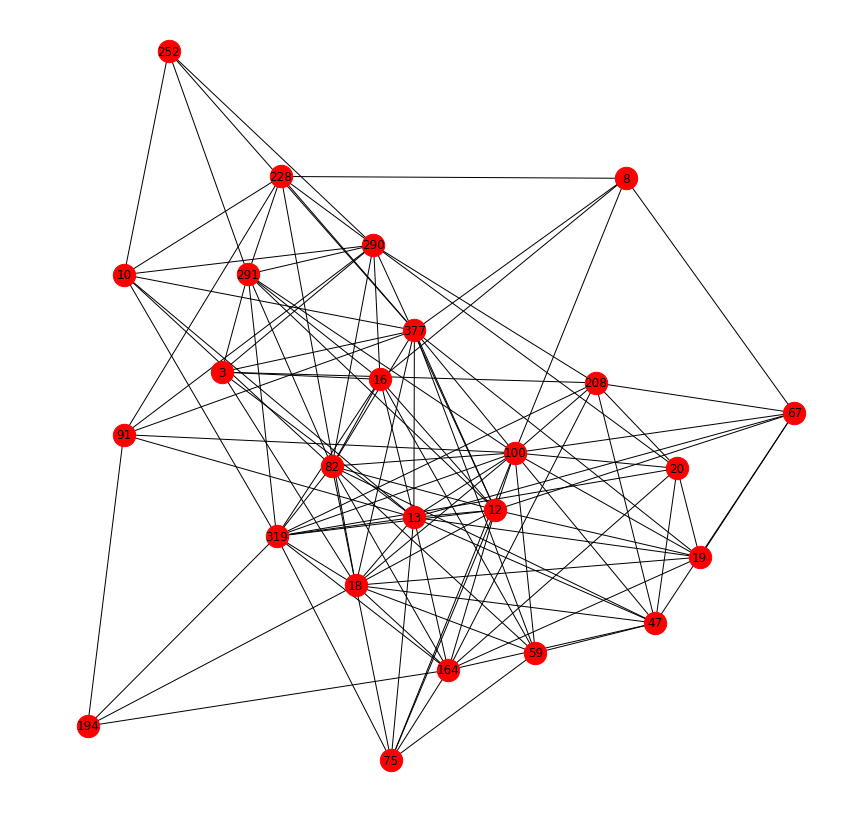

In [157]:
# Subgraph of Most Central Individuals
plt.figure(figsize=(11,11))
G = net.Graph(user_ud)

nodes = G.nodes()
edges = G.edges()

H = net.path_graph(903)
H.add_nodes_from(G)
H.add_edges_from(G.edges())

H2 = H.subgraph(TopNodes)
centralcenter = net.center(H2)
       
net.draw(H2, with_labels=True, node_color = "r", node_size = 500)
